In [1]:
building_id = 2
price = 100
iteration = 0
# we are ready to run!

In [2]:
# Parameters
building_id = 0
price = 300
iteration = 6


In [3]:
############ INPUT FILES  ##############
buildings = ['RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf']

b_name = ['LargeOffice',
         'MediumOffice',
         'SmallOffice',
         'Warehouse']

idf_file   = 'energy_plus/input_building/idf/upgraded/' + buildings[building_id]
# GA
ga_output_dir = 'ga/bc/' + b_name[building_id] + '/{}/'.format(iteration)



# Weather file
epw_file   = 'energy_plus/input_building/epw/' + 'CAN_BC_Vancouver.718920_CWEC.epw'

# EnergyHub
ehub_file  = 'ehub/input_ehub_excel/' + 'bc_three.xlsx'
number_of_panels = 3



In [4]:
########### OUTPUT FILES ###############
import os
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)


# EnergyPlus
output_dir = 'energy_plus/output_energy_plus/' + "{}-{}-{}/".format(building_id,price,iteration)
error_dir  = 'energy_plus/output_energy_plus/' + "{}-{}-{}/".format(building_id,price,iteration)
ensure_dir(output_dir)

# EHUB
ehub_dir   = 'ehub/output_ehub_excel/' + "{}-{}-{}/".format(building_id,price,iteration)
ensure_dir(ehub_dir)
res_file   = ehub_dir + "bc_ehub_results.xlsx"
# PV FACTORS
rendered_files = "rendered_pv_factors/bc/"
ensure_dir(ga_output_dir)
# panel price 400, 200, 106
ga_file = ga_output_dir + "panel_{}_dual.xlsx".format(price)
ga_proc = ga_output_dir + "panel_{}_dual_processed.xlsx".format(price)

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
########### LIBRARIES ###############
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML


# (A) EnergyPlus - North Axis, Electricity & Roof Area

## Run the model:

In [7]:
from pv_model import pvBuilding
# Make the building object
pvbuilding = pvBuilding.PvBuilding(idf_file, out_dir=output_dir, 
                                   epw_file=epw_file, err_dir=error_dir) 

## the North Axis
The north axis gets grabbed automatically from the idf.

In [8]:
pvbuilding.North_Axis

0.0

In [9]:
pvbuilding.Building_Information


Building,
    Ref Bldg Large Office New2004_v1.3_5.0,    !- Name
    0,                        !- North Axis
    City,                     !- Terrain
    0.04,                     !- Loads Convergence Tolerance Value
    0.2,                      !- Temperature Convergence Tolerance Value
    FullInteriorAndExterior,    !- Solar Distribution
    25,                       !- Maximum Number of Warmup Days
    6;                        !- Minimum Number of Warmup Days

## Grab the hourly electricity data
Run the model and store the hourly electricity. 

In [10]:
# Determine the hourly electricity use
pvbuilding.run_ep()

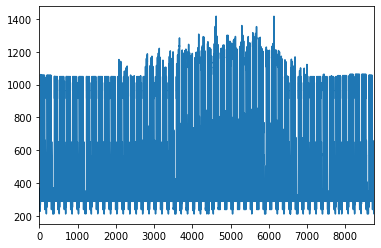

In [11]:
# Show the results in the hourly 
pvbuilding.hourly_electricity.plot()

In [12]:
pvbuilding.max_demand()
pvbuilding.monthly_peak_demand
print(float(pvbuilding.pre_winter_maximum))

The maximum demand charge is: $ 178,523.31
1152.5679573158798


## Grab the Roof Area:
To get the roof area we need to feed the sql_file. 

In [13]:
pvbuilding.get_roof_details()
pvbuilding.p_roof_details()

Roof area is 3,563 m²
Roof area is up 49 m high


# (B) `pvfactors` - Irradience

We will now use pvfactors to find the yearly load of the panels placed at certain angles. Below is some details of how the to translate a panel to the pvfactors package. 


<img src="./images/Example_pvarray.png" alt=""
	title="A cute kitten" width="500" />
    
    
Given that the total area needed is specified by the gcr and the width of the panel:

$\mathrm(ground~area) = \frac{\mathrm(active~area)}{\mathrm(gcr)}$

In [14]:
from pv_model import pvFactors

# Build a pv panel that will live on the building.
pvpanel = pvFactors.PvPanel(rendered_files)
# Setup the Panel on the building. 
# Height of the building and the align the axis with the building
pvpanel.setup_array(pvbuilding)

Calculate the irradiance for a single panel.

/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 8.4085111618042 sec


0.0


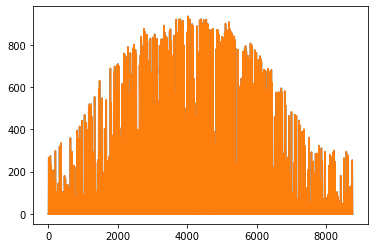

In [15]:
pan_vals = (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)

irr1 = pvpanel.irradiance(100,1,0.25,force_recalc=False)
plt.plot(irr1);
type(irr1)
irr2 = pvpanel.irradiance(100,1,0.25,force_recalc=True)
plt.plot(irr2);
print(max(irr1-irr2))

# (C) EnergyHub - Cost and Capacity installed

## Model for BC


| **Name**                 | **Small**        | **Medium**              | **Large**                                            | **Details**                                                                                                                                                    |
| :----------------------- | :--------------- | :---------------------- | :--------------------------------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Technical Constraint** | Demand \< 35kW   | Demand \>35kW \& \<150kW | Larger than \>150kW or Total energy use \>550,000kWh | Demand is the peak energy use in kW for each month.                                                                                                            |
| Basic Charge             | \$ 0.3645 /day    | \$ 0.2673 /day           | \$ 0.2673 /day                                        |                                                                                                                                                                |
| Demand Charge            | \-               | \$ 5.42/kW               | \$ 12.34/kW                                           | Based on the monthly peak load                                                                                                                                 |
| Energy Charge            | \$ 0.1253 /kWh    | \$ 0.0986 /kWh           | \$ 0.0606 /kWh                                        |                                                                                                                                                                |
| Minimum Charge           | The basic charge | The Minimum charge      | The Minimum Charge                                   | The mimimum charge is equal to 50% of highest winter months demand charge, if the sum of the basic, demand and energy charge is less than this minimum charge. |
| Power Factor Surcharge   | \-               | \-                      | \-                                                   | At low powerfactors                                                                                                                                            |
| Discounts                | \-               | \-                      | \-                                                   | Maintaining good power quality                                                                                                                                 |
| Taxes                    | \-               | \-                      | \-                                                   |                                                                                                                                                                |


(215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)
Loading the model
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 1.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 26.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 36.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


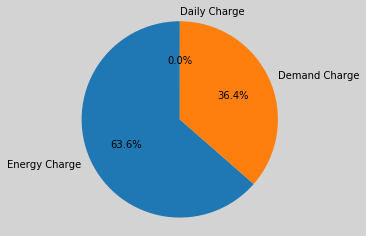

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%


In [16]:
from pv_model import pvModel
# These are the fixed five panels that we are interested in
if (number_of_panels==5):
    azi = [180,215,245,215,130]
    tilt = [35,55,10,35,5]
    gcr = [0.6,0.35,0.9,0.7,0.9]
# These are the fixed three panels that we are interested in
if (number_of_panels==3):
    azi = [180,215,245]
    tilt = [35,55,10]
    gcr = [0.9,0.35,0.9]
# Setup the values array
pan_vals = []
pan_vals.extend(azi)
pan_vals.extend(tilt)
pan_vals.extend(gcr)

pan_vals = (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)

print(pan_vals)

# setup the gcr
area_per_panel = [pvpanel.pp['pvrow_depth']*pvpanel.pp['pvrow_width']/gcr[i] for i in range(number_of_panels)]
roof_area_per_unit_capacity = {"PV{}".format(i):area_per_panel[i]  for i in range(number_of_panels)}
# Here's where we instantiate our model. Nothing is solved at this point.
print("Loading the model")
my_model = pvModel.ModelBC(excel         = ehub_file,\
                           pvbuilding    = pvbuilding,\
                           resultsFile   = res_file,\
                           ROOF_AREA_CAP = roof_area_per_unit_capacity,
                           NUM_PANELS    = number_of_panels)
my_model.eval_model(pan_vals,400,pvpanel)

After evaluating the model we can plot the results. This is a pie chart that breaks down the total cost into the off,on and mid peak costs. 

In [17]:
my_model.energyIm

5141400.0

In [18]:
my_model.solveResults['solution']['demand_charge_c'].sum()

demand_charge_c    178523.4
dtype: float64

In [19]:
print(my_model.solveResults['solution']['monthly_import'])
print(my_model.solveResults['solution']['monthly_import'].sum())
print(my_model.solveResults['solution']['total_import'])

print(my_model.solveResults['solution']['monthly_export'])
print(my_model.solveResults['solution']['monthly_export'].sum())
print(my_model.solveResults['solution']['total_export'])
print(my_model.solveResults['solution']['daily_charge_c'])


     monthly_import
Apr        395147.0
Aug        514587.0
Dec        402070.0
Feb        367362.0
Jan        408575.0
Jul        478270.0
Jun        463664.0
Mar        424326.0
May        438232.0
Nov        398329.0
Oct        413882.0
Sep        436953.0
monthly_import    5141397.0
dtype: float64
5141400.0
     monthly_export
Apr             0.0
Aug             0.0
Dec             0.0
Feb             0.0
Jan             0.0
Jul             0.0
Jun             0.0
Mar             0.0
May             0.0
Nov             0.0
Oct             0.0
Sep             0.0
monthly_export    0.0
dtype: float64
0.0
97.5645


In [20]:
my_model.solveResults['solution']['daily_charge_c']

97.5645

In [21]:
my_model.solveResults['solution']['is_installed']

is_installed
GreenEng             0
Grid                 1
Invertor             0
PV0                  0
PV1                  0
PV2                  0

In [22]:
my_model.solveResults['solution']['any_above_35']

1

In [23]:
my_model.solveResults['solution']['a150_or_a550']

1

# (D) GA - Optimize the model

In [24]:
from pv_model import pvOptimizer

range_azi  = range(90,270,5)
range_tilt = range(1,61,5)
range_gcr  = np.arange(0.2, .95, 0.05)

ERROR:optimizer_logger:Started {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 300}


ERROR:optimizer_logger:0


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 300}


The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (160, 200, 160, 46, 6, 21, 0.39999999999999997, 0.44999999999999996, 0.39999999999999997)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 46.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 6.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 21.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


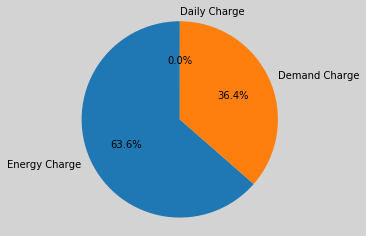

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (250, 160, 225, 41, 16, 46, 0.5999999999999999, 0.5999999999999999, 0.7999999999999998)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 41.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 16.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 46.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.567148447036743 sec


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


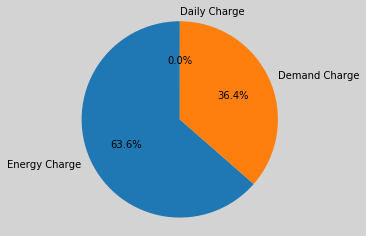

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (245, 140, 125, 6, 56, 36, 0.5999999999999999, 0.8499999999999999, 0.7499999999999998)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 6.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 56.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 36.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


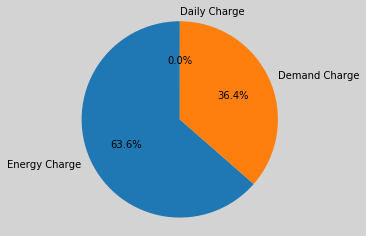

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (100, 215, 210, 56, 26, 26, 0.25, 0.49999999999999994, 0.6499999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 56.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 26.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 26.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


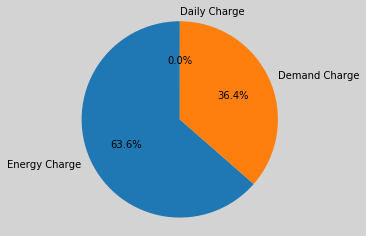

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (100, 265, 135, 46, 16, 21, 0.49999999999999994, 0.39999999999999997, 0.39999999999999997)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 46.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 16.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 21.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


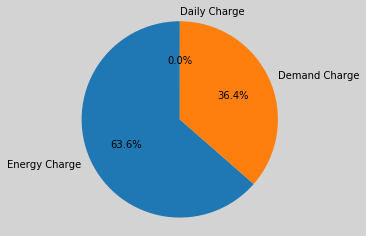

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (200, 95, 125, 6, 41, 51, 0.7, 0.8499999999999999, 0.8999999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 6.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 41.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 51.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


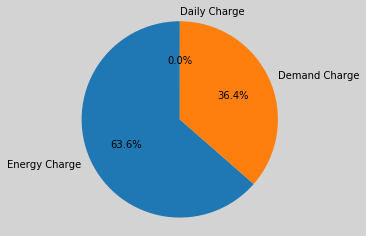

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (250, 265, 255, 11, 21, 36, 0.7499999999999998, 0.7499999999999998, 0.7499999999999998)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 11.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 21.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 36.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 74s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


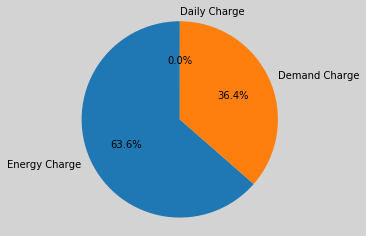

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (145, 145, 100, 46, 11, 36, 0.44999999999999996, 0.7999999999999998, 0.44999999999999996)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 46.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 11.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 36.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


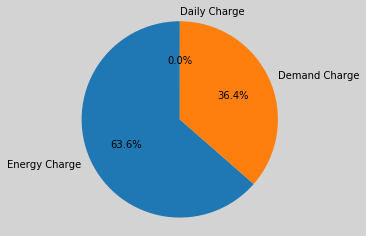

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (215, 95, 100, 21, 16, 46, 0.7999999999999998, 0.35, 0.35)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 21.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 16.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 46.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


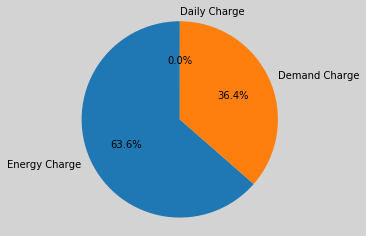

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (145, 105, 150, 41, 16, 41, 0.39999999999999997, 0.8499999999999999, 0.39999999999999997)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 41.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 16.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 41.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


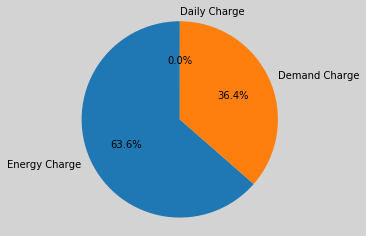

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (190, 145, 130, 21, 31, 16, 0.7999999999999998, 0.49999999999999994, 0.3)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 21.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.5284833908081055 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 31.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 16.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


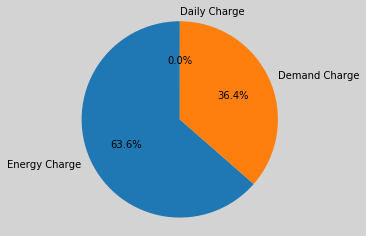

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (170, 170, 210, 16, 6, 16, 0.25, 0.5499999999999999, 0.8999999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 16.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 6.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 16.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


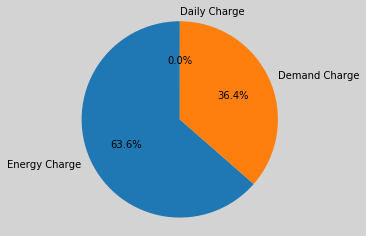

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (130, 145, 155, 11, 11, 26, 0.6499999999999999, 0.5499999999999999, 0.39999999999999997)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 11.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 11.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 26.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


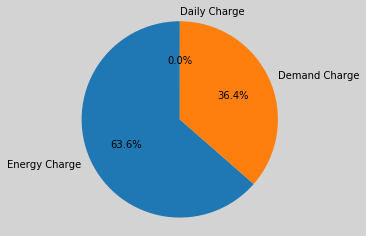

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (130, 210, 155, 6, 31, 31, 0.7999999999999998, 0.7, 0.49999999999999994)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 6.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 31.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 31.0
                                           and a gcr of 0.500


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 10.011396408081055 sec


ERROR:ga_logger:Generated the panel irradiance in  10s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


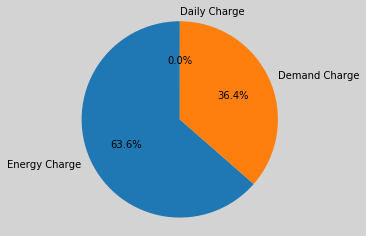

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (160, 130, 210, 36, 36, 56, 0.5999999999999999, 0.49999999999999994, 0.39999999999999997)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 36.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 130
                                           a tilt of 36.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 56.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


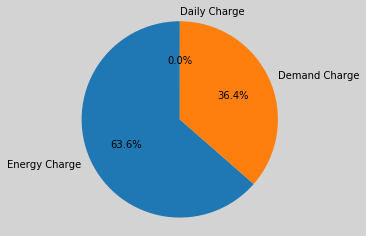

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (240, 120, 190, 31, 16, 31, 0.44999999999999996, 0.7, 0.3)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 31.0
                                           and a gcr of 0.450


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.344866037368774 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 120
                                           a tilt of 16.0
                                           and a gcr of 0.700


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.96541690826416 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 31.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in  13s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


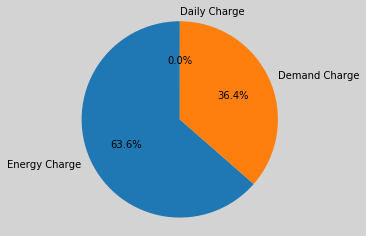

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (100, 170, 165, 6, 26, 36, 0.5499999999999999, 0.8499999999999999, 0.3)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 6.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 26.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 36.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


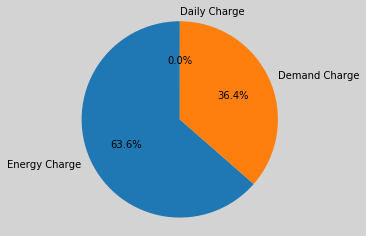

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (120, 210, 125, 26, 16, 6, 0.3, 0.25, 0.44999999999999996)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 120
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 16.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 6.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


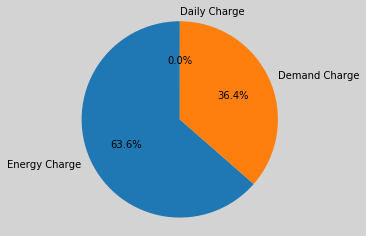

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (220, 165, 115, 26, 36, 41, 0.8499999999999999, 0.8999999999999999, 0.8999999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 220
                                           a tilt of 26.0
                                           and a gcr of 0.850


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.200983285903931 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 36.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 41.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


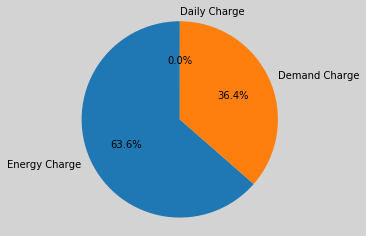

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (250, 235, 230, 26, 11, 11, 0.7499999999999998, 0.39999999999999997, 0.8999999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 26.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 11.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 11.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


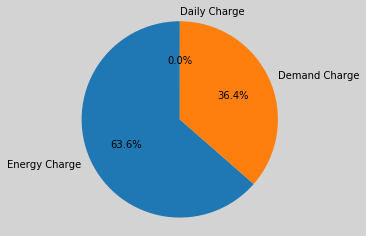

ERROR:optimizer_logger:20


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 300}


Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (200, 115, 220, 21, 11, 51, 0.39999999999999997, 0.39999999999999997, 0.35)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 21.0
                                           and a gcr of 0.400


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 8.35055947303772 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 11.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 51.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   9s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


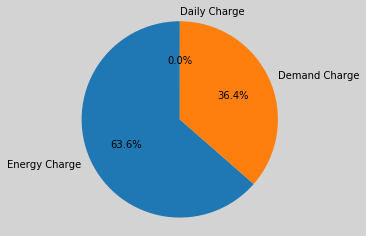

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (175, 200, 185, 11, 41, 21, 0.44999999999999996, 0.8499999999999999, 0.7999999999999998)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 11.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 41.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 21.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


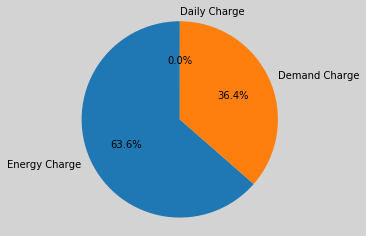

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (185, 205, 230, 1, 46, 56, 0.25, 0.5499999999999999, 0.6499999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 1.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 46.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 56.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


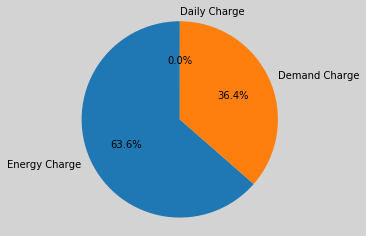

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (155, 155, 150, 41, 1, 36, 0.5499999999999999, 0.44999999999999996, 0.8499999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 41.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 1.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 36.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


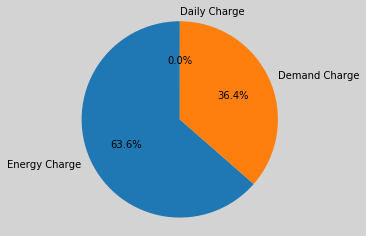

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (160, 160, 250, 51, 26, 56, 0.8999999999999999, 0.35, 0.49999999999999994)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 51.0
                                           and a gcr of 0.900


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.53695011138916 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 26.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 56.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


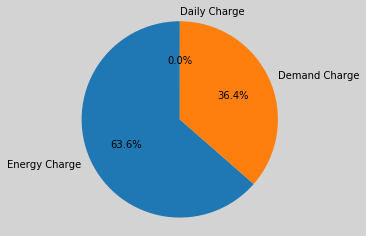

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (210, 160, 120, 56, 16, 11, 0.44999999999999996, 0.8999999999999999, 0.25)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 210
                                           a tilt of 56.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 16.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 11.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


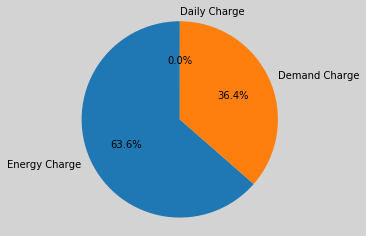

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (220, 265, 105, 51, 6, 51, 0.3, 0.49999999999999994, 0.8999999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 220
                                           a tilt of 51.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 6.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 51.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


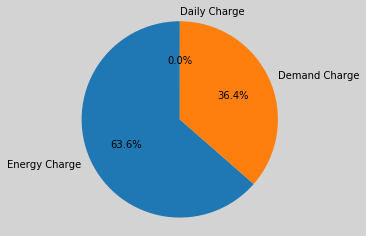

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (170, 215, 185, 16, 31, 56, 0.6499999999999999, 0.44999999999999996, 0.6499999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 16.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 31.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 56.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


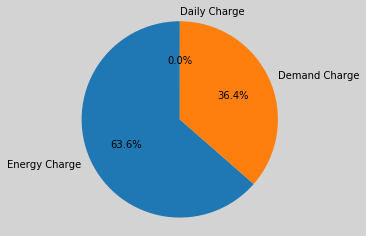

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (195, 135, 250, 46, 46, 21, 0.6499999999999999, 0.2, 0.35)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 46.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 46.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 21.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


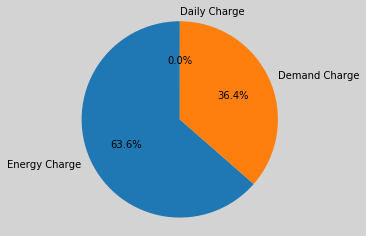

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (210, 175, 190, 36, 41, 21, 0.8999999999999999, 0.5999999999999999, 0.25)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 210
                                           a tilt of 36.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 41.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 21.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


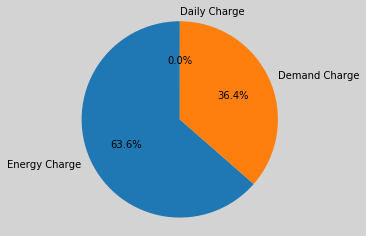

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (180, 165, 90, 1, 46, 26, 0.7499999999999998, 0.5499999999999999, 0.39999999999999997)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 1.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 46.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 26.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


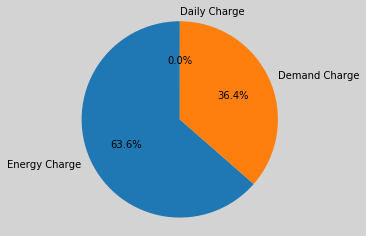

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (130, 200, 115, 36, 1, 46, 0.7499999999999998, 0.7999999999999998, 0.5999999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 36.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 1.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 46.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


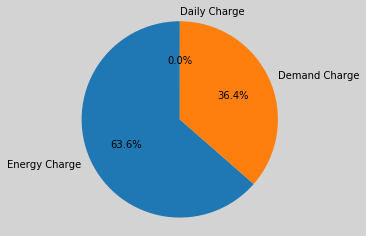

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (255, 210, 110, 21, 16, 56, 0.7, 0.7999999999999998, 0.39999999999999997)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 21.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 16.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 56.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


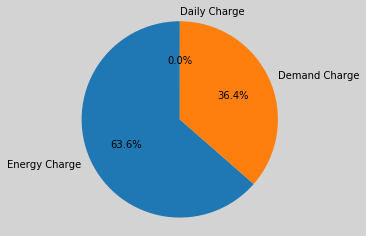

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (100, 90, 135, 11, 11, 26, 0.8999999999999999, 0.6499999999999999, 0.3)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 11.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 11.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


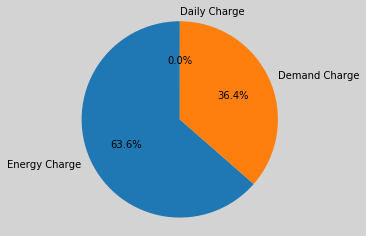

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (220, 265, 200, 16, 41, 56, 0.5999999999999999, 0.2, 0.5499999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 220
                                           a tilt of 16.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 41.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 200
                                           a tilt of 56.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


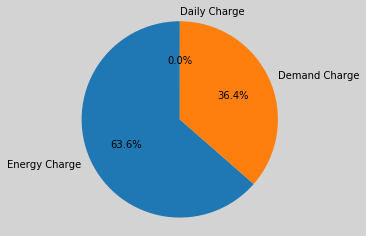

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (180, 120, 130, 26, 6, 36, 0.39999999999999997, 0.7999999999999998, 0.3)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 26.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 120
                                           a tilt of 6.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 36.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


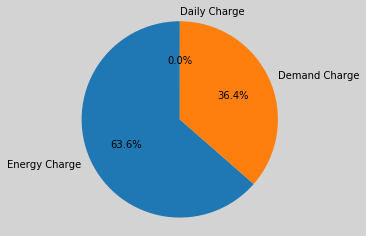

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (245, 90, 150, 41, 41, 1, 0.5499999999999999, 0.8999999999999999, 0.25)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 41.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 41.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 1.0
                                           and a gcr of 0.250


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.61581015586853 sec


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


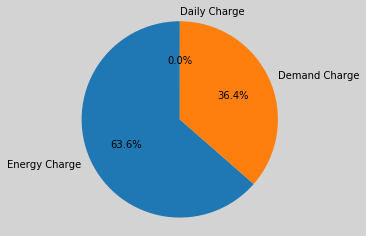

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (190, 225, 185, 46, 46, 41, 0.5999999999999999, 0.39999999999999997, 0.3)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 46.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 46.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 41.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


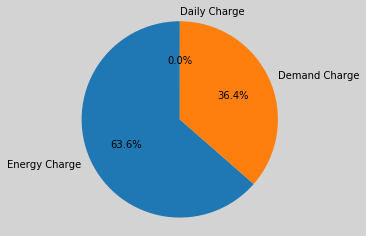

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (125, 135, 140, 41, 16, 21, 0.8499999999999999, 0.2, 0.39999999999999997)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 41.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 16.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.337311267852783 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 21.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


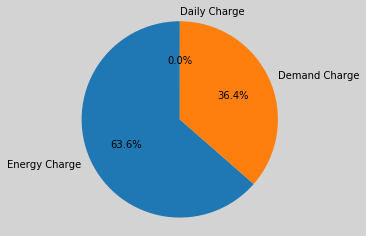

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (180, 105, 200, 36, 41, 16, 0.8499999999999999, 0.2, 0.35)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 36.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 41.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.832117080688477 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 200
                                           a tilt of 16.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


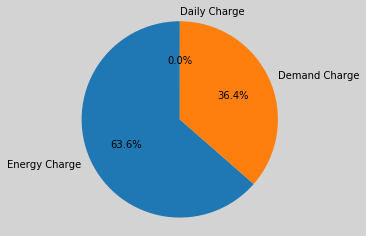

ERROR:optimizer_logger:40


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 300}


Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (165, 145, 210, 1, 46, 31, 0.25, 0.8999999999999999, 0.44999999999999996)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 1.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 46.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 31.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


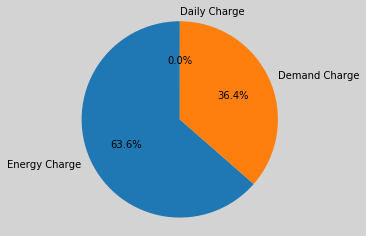

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (200, 255, 240, 31, 21, 36, 0.49999999999999994, 0.7999999999999998, 0.7999999999999998)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 31.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 21.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 240
                                           a tilt of 36.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


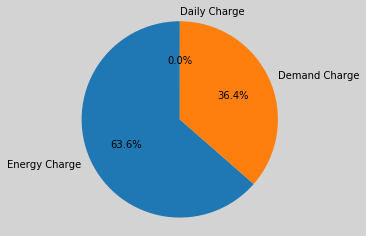

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (195, 100, 125, 26, 1, 11, 0.25, 0.5999999999999999, 0.35)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 26.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 1.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 11.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 74s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


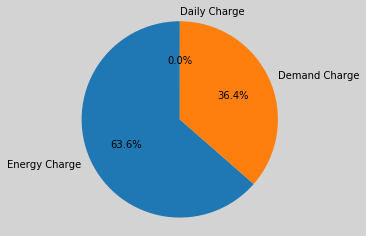

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (100, 160, 255, 36, 1, 1, 0.6499999999999999, 0.3, 0.35)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 36.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 1.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 1.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


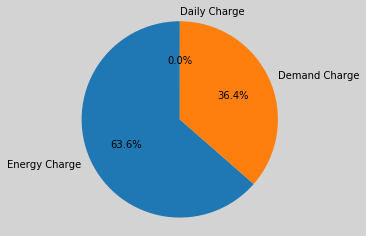

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (160, 255, 225, 51, 41, 36, 0.5999999999999999, 0.8499999999999999, 0.39999999999999997)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 51.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 41.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 36.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


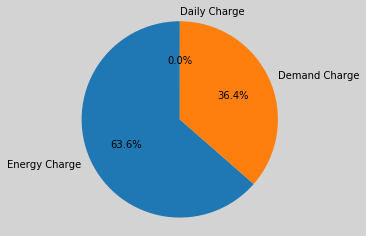

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (200, 140, 190, 6, 46, 11, 0.39999999999999997, 0.25, 0.6499999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 6.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 46.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 11.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


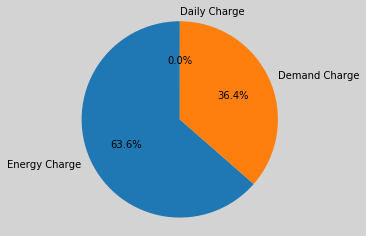

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (220, 135, 120, 16, 46, 1, 0.5499999999999999, 0.8499999999999999, 0.3)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 220
                                           a tilt of 16.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 46.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 1.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


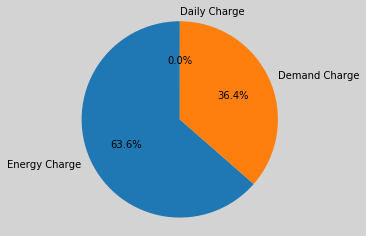

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (245, 160, 170, 41, 41, 16, 0.7499999999999998, 0.44999999999999996, 0.7999999999999998)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 41.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 41.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 16.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


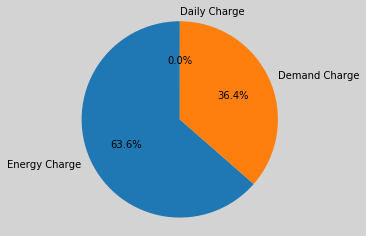

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (165, 175, 250, 6, 56, 51, 0.6499999999999999, 0.3, 0.7499999999999998)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 6.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 56.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 51.0
                                           and a gcr of 0.750


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.979960203170776 sec


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


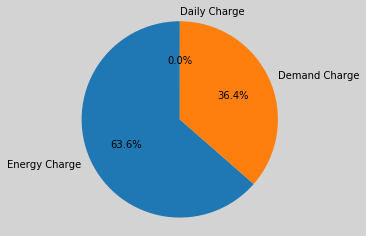

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (225, 90, 175, 16, 51, 11, 0.7499999999999998, 0.25, 0.2)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 16.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 51.0
                                           and a gcr of 0.250


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 13.414375305175781 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 11.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in  14s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


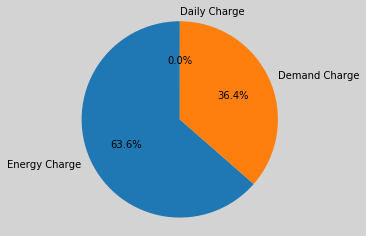

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (130, 150, 145, 31, 46, 11, 0.8999999999999999, 0.35, 0.49999999999999994)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 31.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 46.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 145
                                           a tilt of 11.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


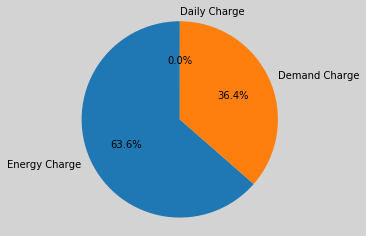

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (255, 230, 220, 16, 31, 1, 0.7, 0.25, 0.35)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 16.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 31.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 1.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


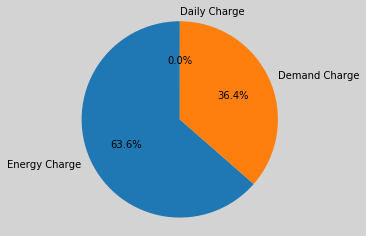

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (255, 130, 190, 46, 1, 36, 0.5999999999999999, 0.35, 0.3)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 46.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 130
                                           a tilt of 1.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.83734130859375 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 36.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


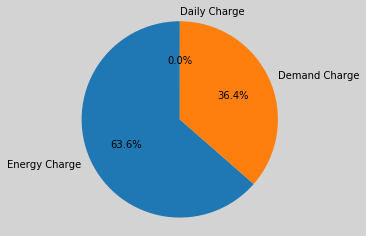

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (105, 185, 165, 51, 16, 46, 0.6499999999999999, 0.7, 0.39999999999999997)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 105
                                           a tilt of 51.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 16.0
                                           and a gcr of 0.700


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.903126239776611 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 46.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


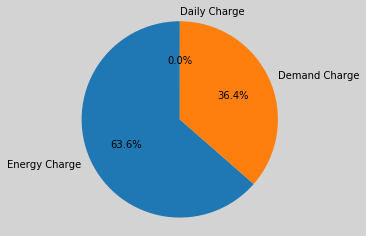

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (130, 100, 125, 46, 31, 11, 0.49999999999999994, 0.25, 0.8999999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 46.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 31.0
                                           and a gcr of 0.250


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.6602373123168945 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 11.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 74s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


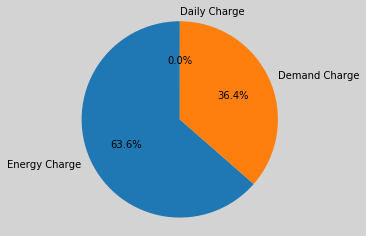

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (170, 160, 95, 41, 56, 16, 0.7, 0.39999999999999997, 0.3)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 41.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 56.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 16.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


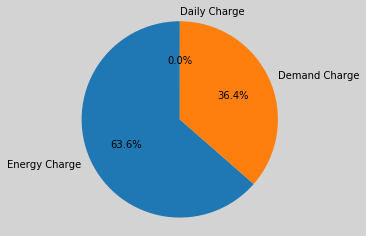

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (125, 225, 105, 41, 26, 26, 0.5499999999999999, 0.44999999999999996, 0.7499999999999998)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 41.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 26.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 26.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


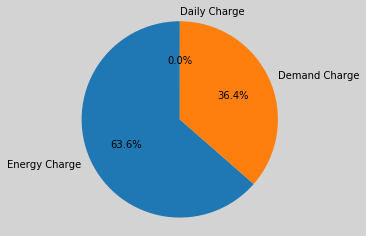

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (215, 220, 230, 46, 51, 31, 0.3, 0.5999999999999999, 0.5999999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 46.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 51.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 31.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


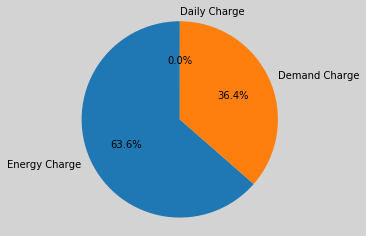

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (110, 105, 90, 16, 26, 31, 0.7499999999999998, 0.5999999999999999, 0.8999999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 16.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 26.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 31.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


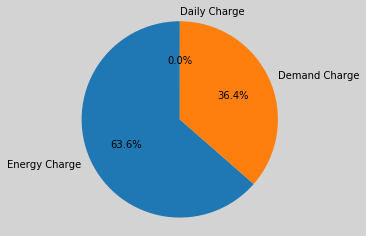

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (250, 100, 245, 51, 31, 36, 0.3, 0.35, 0.7999999999999998)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 51.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 31.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 36.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


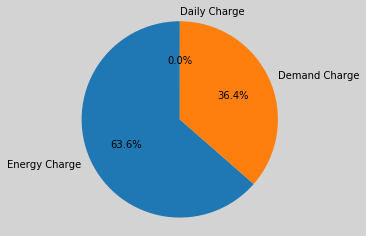

ERROR:optimizer_logger:60


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 300}


Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (165, 205, 175, 11, 21, 16, 0.5999999999999999, 0.44999999999999996, 0.8499999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 11.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 21.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 16.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 67s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


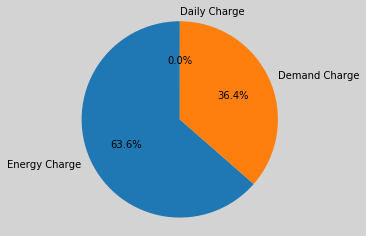

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (200, 225, 155, 51, 26, 46, 0.3, 0.3, 0.5999999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 51.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 46.0
                                           and a gcr of 0.600


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.541245698928833 sec


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 74s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


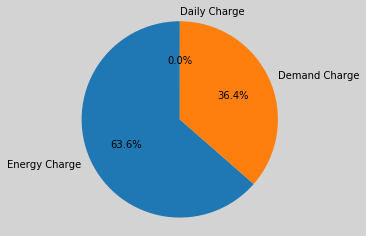

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (130, 215, 170, 21, 31, 31, 0.8999999999999999, 0.5999999999999999, 0.8499999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 21.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 31.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 31.0
                                           and a gcr of 0.850


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.691401958465576 sec


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


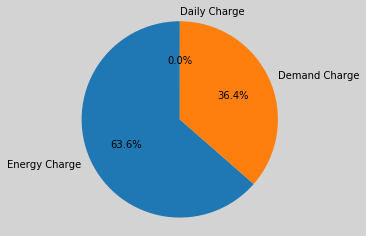

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (245, 90, 265, 21, 26, 31, 0.7, 0.7, 0.39999999999999997)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 21.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 26.0
                                           and a gcr of 0.700


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 9.286214113235474 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 31.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in  10s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


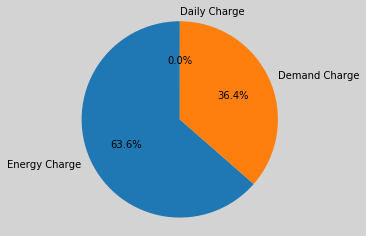

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (255, 225, 105, 46, 41, 26, 0.35, 0.39999999999999997, 0.8999999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 46.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 41.0
                                           and a gcr of 0.400


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 11.03101134300232 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 26.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in  11s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


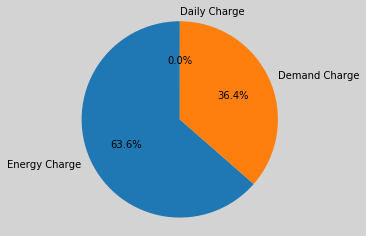

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (195, 260, 175, 16, 26, 1, 0.2, 0.7499999999999998, 0.7499999999999998)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 16.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 26.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 1.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


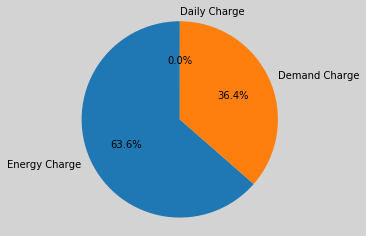

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (175, 160, 140, 6, 16, 46, 0.35, 0.7999999999999998, 0.5999999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 6.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.962457180023193 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 16.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.155109643936157 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 46.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in  15s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


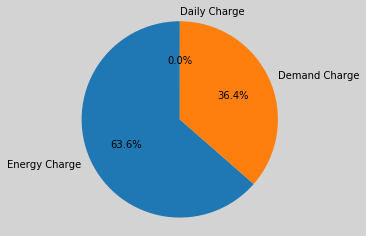

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (200, 110, 140, 41, 6, 46, 0.5499999999999999, 0.7, 0.8499999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 41.0
                                           and a gcr of 0.550


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 18.38843607902527 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 6.0
                                           and a gcr of 0.700


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.171504735946655 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 46.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in  25s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


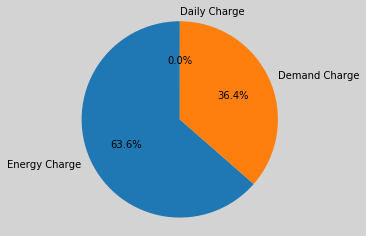

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (160, 205, 230, 6, 41, 41, 0.8999999999999999, 0.6499999999999999, 0.49999999999999994)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 6.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 41.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 41.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


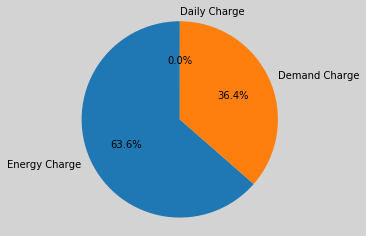

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (245, 255, 135, 1, 11, 51, 0.7, 0.2, 0.8499999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 1.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 11.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 51.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


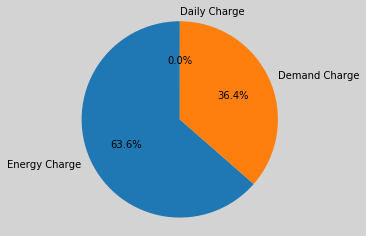

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (160, 225, 140, 1, 41, 41, 0.44999999999999996, 0.7, 0.8499999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 1.0
                                           and a gcr of 0.450


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.667819499969482 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 41.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 41.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


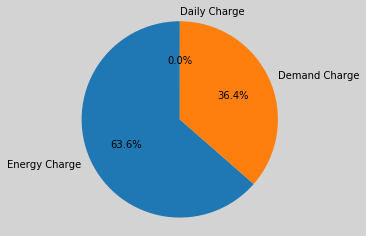

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (265, 245, 135, 41, 41, 1, 0.25, 0.6499999999999999, 0.35)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 41.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 41.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 1.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.676371097564697 sec


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


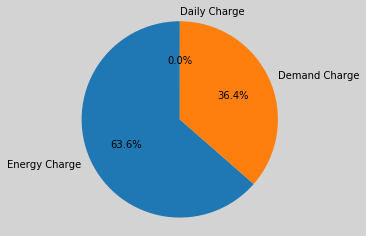

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (190, 245, 240, 56, 21, 56, 0.8499999999999999, 0.7499999999999998, 0.3)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 56.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 21.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 240
                                           a tilt of 56.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


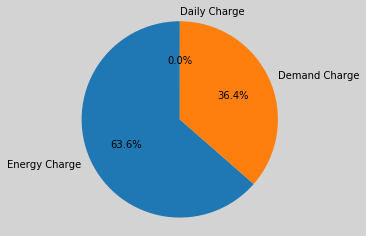

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (100, 150, 200, 51, 56, 6, 0.49999999999999994, 0.49999999999999994, 0.5499999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 51.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 56.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 200
                                           a tilt of 6.0
                                           and a gcr of 0.550


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 8.143577337265015 sec


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


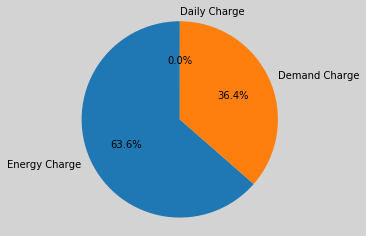

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (145, 195, 265, 21, 26, 11, 0.6499999999999999, 0.44999999999999996, 0.2)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 21.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 26.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 11.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


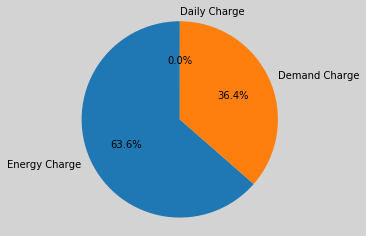

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (165, 170, 265, 51, 46, 21, 0.7, 0.49999999999999994, 0.39999999999999997)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 51.0
                                           and a gcr of 0.700


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 9.66620135307312 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 46.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 21.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in  10s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


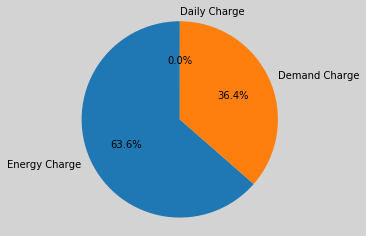

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (110, 155, 160, 31, 6, 21, 0.8499999999999999, 0.6499999999999999, 0.8999999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 31.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 6.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 21.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


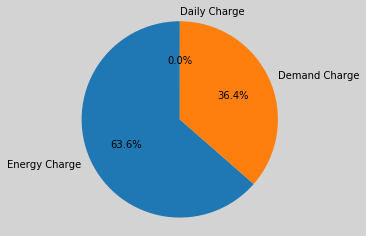

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (125, 195, 200, 46, 31, 36, 0.35, 0.7, 0.6499999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 46.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 31.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 200
                                           a tilt of 36.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


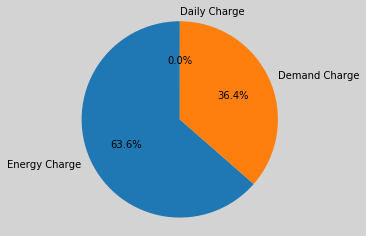

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (205, 145, 195, 26, 41, 36, 0.6499999999999999, 0.8999999999999999, 0.49999999999999994)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 26.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 41.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 36.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


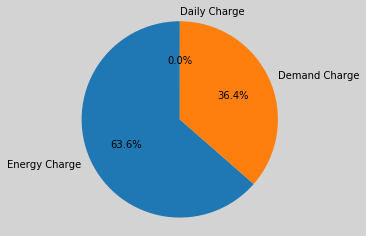

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (190, 115, 140, 1, 46, 31, 0.35, 0.7, 0.5499999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 1.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 46.0
                                           and a gcr of 0.700


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.077120542526245 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 31.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


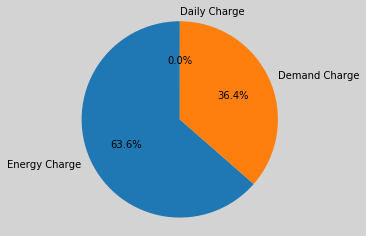

ERROR:optimizer_logger:80


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 300}


Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (90, 220, 115, 31, 56, 6, 0.8999999999999999, 0.2, 0.8999999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 31.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 56.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 10.166029930114746 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 6.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in  10s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


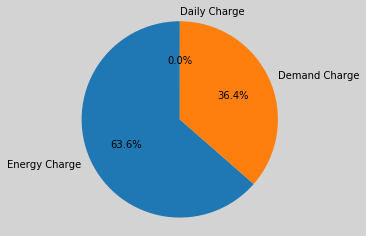

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (195, 205, 135, 1, 56, 31, 0.5499999999999999, 0.49999999999999994, 0.8999999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 1.0
                                           and a gcr of 0.550


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.768426179885864 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 56.0
                                           and a gcr of 0.500


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.727307319641113 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 31.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in  15s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


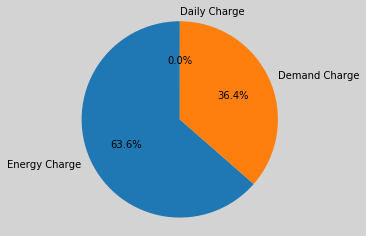

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (235, 100, 140, 56, 56, 41, 0.2, 0.39999999999999997, 0.7999999999999998)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 235
                                           a tilt of 56.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 56.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 41.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


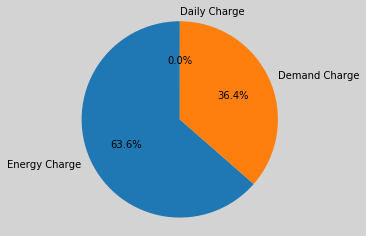

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (185, 255, 130, 31, 46, 1, 0.8999999999999999, 0.7499999999999998, 0.8499999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 31.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 46.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 1.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


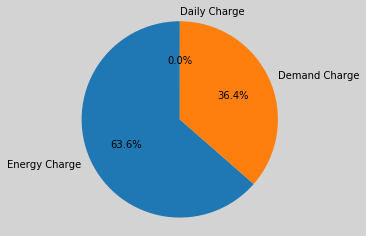

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (150, 150, 155, 16, 46, 16, 0.39999999999999997, 0.2, 0.3)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 16.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 46.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 16.0
                                           and a gcr of 0.300


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 9.6244375705719 sec


ERROR:ga_logger:Generated the panel irradiance in  10s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 92s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


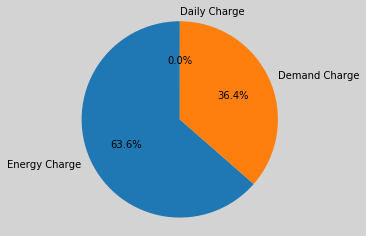

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (195, 220, 150, 16, 31, 16, 0.7, 0.8499999999999999, 0.8499999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 16.0
                                           and a gcr of 0.700


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 9.980294942855835 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 31.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 16.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in  10s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


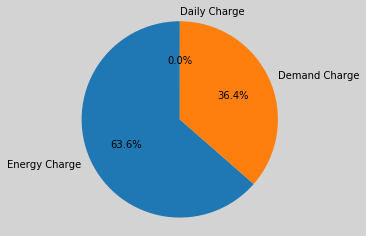

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (110, 205, 130, 36, 46, 11, 0.7999999999999998, 0.8999999999999999, 0.7499999999999998)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 36.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 46.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 11.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


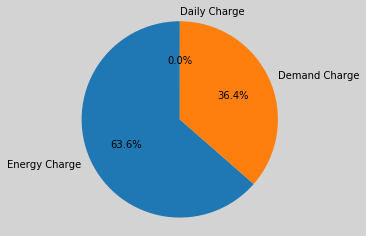

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (140, 255, 250, 26, 11, 26, 0.5499999999999999, 0.49999999999999994, 0.8499999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 26.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 11.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 26.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


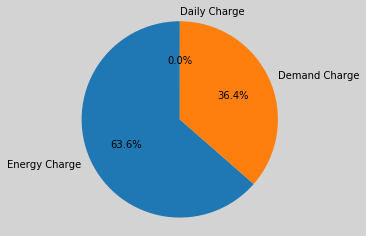

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (130, 90, 165, 51, 41, 36, 0.3, 0.8499999999999999, 0.5999999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 51.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 41.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 36.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 73s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


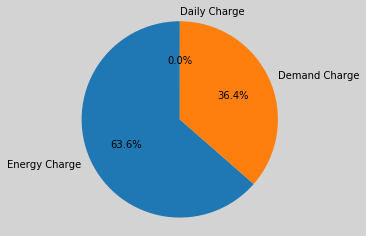

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (220, 250, 135, 41, 56, 41, 0.49999999999999994, 0.25, 0.2)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 220
                                           a tilt of 41.0
                                           and a gcr of 0.500


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.665571928024292 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 250
                                           a tilt of 56.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 41.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


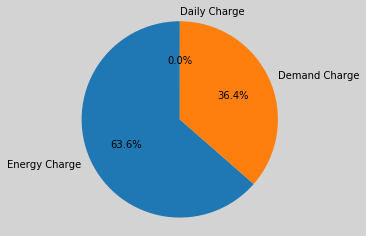

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (185, 155, 150, 31, 1, 6, 0.8499999999999999, 0.44999999999999996, 0.44999999999999996)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 31.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 1.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 6.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


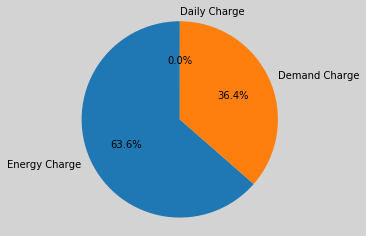

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (120, 265, 95, 21, 36, 26, 0.6499999999999999, 0.7, 0.5999999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 120
                                           a tilt of 21.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 36.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 26.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 73s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


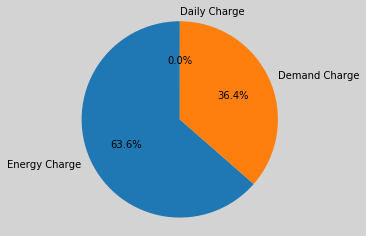

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (175, 225, 260, 31, 16, 21, 0.8999999999999999, 0.7999999999999998, 0.5999999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 31.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 16.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 21.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


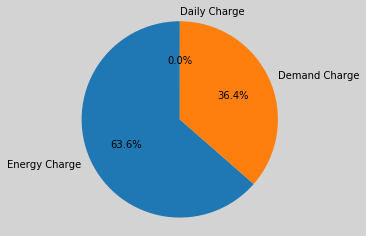

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (220, 190, 240, 56, 6, 31, 0.7499999999999998, 0.7999999999999998, 0.8499999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 220
                                           a tilt of 56.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 6.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 240
                                           a tilt of 31.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


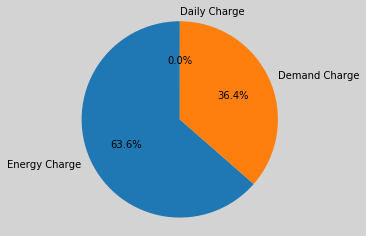

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (255, 185, 125, 31, 41, 26, 0.5999999999999999, 0.35, 0.44999999999999996)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 31.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 41.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 26.0
                                           and a gcr of 0.450


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.002089977264404 sec


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


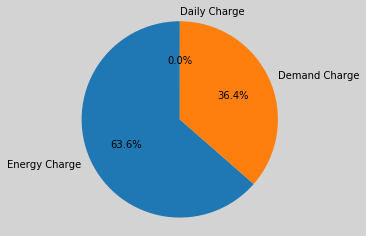

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (165, 205, 170, 51, 11, 21, 0.7499999999999998, 0.39999999999999997, 0.5999999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 51.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 11.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 21.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


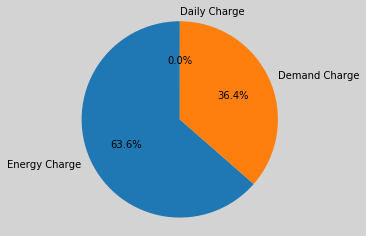

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (230, 185, 205, 51, 51, 31, 0.39999999999999997, 0.39999999999999997, 0.6499999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 51.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 51.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 31.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


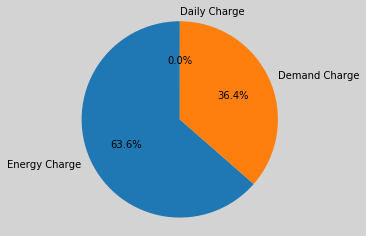

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (200, 225, 260, 1, 16, 31, 0.5999999999999999, 0.39999999999999997, 0.7499999999999998)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 1.0
                                           and a gcr of 0.600


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 10.910704851150513 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 16.0
                                           and a gcr of 0.400


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.283925533294678 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 31.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in  18s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


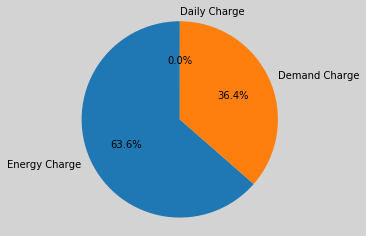

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (250, 260, 105, 26, 41, 26, 0.3, 0.25, 0.39999999999999997)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 41.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 26.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 69s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


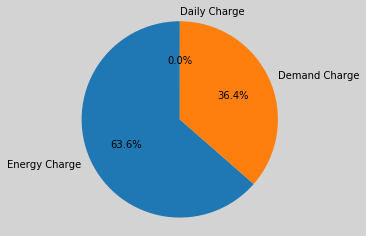

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (115, 250, 90, 6, 31, 6, 0.5999999999999999, 0.2, 0.5499999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 6.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 250
                                           a tilt of 31.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 9.321385145187378 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 6.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in  10s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 74s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


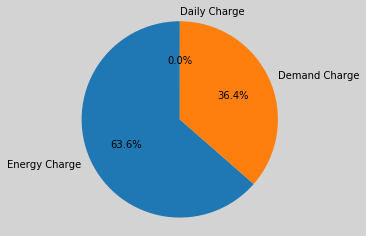

ERROR:optimizer_logger:100


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 300}


ERROR:optimizer_logger:Finished and stored: {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 300}


Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
1
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: azi0      90
azi1     220
azi2     115
tilt0     31
tilt1     56
tilt2      6
gcr0     0.9
gcr1     0.2
gcr2     0.9
Name: 0, dtype: object


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 31.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 56.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 6.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


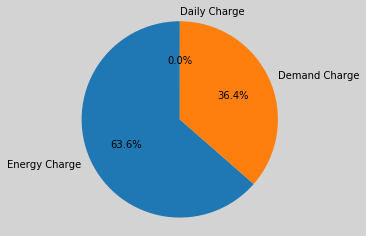

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
[[90, 220, 115, 31, 56, 6, 0.8999999999999999, 0.2, 0.8999999999999999, 490190.0, 0.0, 0.0, 0.0, 0.0, 1, 'red', {'Levelized Costs': 0.4355000000291085, 'Energy Charge': 311568.6, 'Demand Charge': 178523.4, 'Daily Charge': 97.5645}, 0.0, 5141400.0, 0.0]]


In [25]:
pvoptimizer = pvOptimizer.PvOptimizer(range_azi=range_azi,
                 range_tilt=range_tilt,
                 range_gcr=range_gcr,
                 pvpanel=pvpanel,
                 price=price,
                 store_file=ga_file,
                 ehub_file=ehub_file,
                 res_file=res_file,
                 pvbuilding=pvbuilding,
                 roof_area_per_unit_capacity=roof_area_per_unit_capacity)
pvoptimizer.runGA(100,20,"BC","DUAL")
pvoptimizer.processGA(ga_proc)